In [20]:
# This ensures that our graphs will be shown properly in the notebook.
%matplotlib inline

# Import a few libraries we need
from zipline import run_algorithm

from zipline.api import order_target_percent, record, symbol
from datetime import datetime
import pytz
import matplotlib.pyplot as plt
import pandas as pd
import pyfolio as pf

def initialize(context):
    # Which stock to trade
    dji = ["STZ","TAP","BREW","SAM"]
    
    # Make a list of symbols from the list of tickers
    context.dji_symbols = [symbol(s) for s in dji]
    
    # Moving average window
    context.index_average_window = 50

In [21]:
def handle_data(context, data):
    # Get history for all the stocks
    stock_hist = data.history(context.dji_symbols, "close", context.index_average_window, "1d")
    
    # Make an empty DataFrame to start with
    stock_analytics = pd.DataFrame()
    
    # Add column for above or below average
    stock_analytics['above_mean'] = stock_hist.iloc[-1] > stock_hist.mean() 
    
    # Set weight for stocks to buy
    stock_analytics.loc[stock_analytics['above_mean'] == True, 'weight'] = 1/len(context.dji_symbols)
    
    # Set weight to zero for the rest
    stock_analytics.loc[stock_analytics['above_mean'] == False, 'weight'] = 0.0
    
    # Iterate each row and place trades
    for stock, analytics in stock_analytics.iterrows():
        # Check if the stock can be traded
        if data.can_trade(stock):
            # Place the trade
            order_target_percent(stock, analytics['weight'])

In [22]:
def analyze(context, perf):
    fig = plt.figure(figsize=(12, 8))
    
    # First chart
    ax = fig.add_subplot(311)
    ax.set_title('Strategy Results')
    ax.plot(perf['portfolio_value'], linestyle='-', 
                label='Equity Curve', linewidth=3.0)
    ax.legend()
    ax.grid(False)
    
    # Second chart
    ax = fig.add_subplot(312)
    ax.plot(perf['gross_leverage'], 
            label='Exposure', linestyle='-', linewidth=1.0)
    ax.legend()
    ax.grid(True)

    # Third chart
    ax = fig.add_subplot(313)
    ax.plot(perf['returns'], label='Returns', linestyle='-.', linewidth=1.0)
    ax.legend()
    ax.grid(True)
    
    returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    pf.create_returns_tear_sheet(returns, benchmark_rets=None)

In [30]:
# Set start and end date
start_date = pd.to_datetime('2007-1-1', utc=True)
end_date = pd.to_datetime('2017-12-31', utc=True)
type(start_date)

pandas._libs.tslib.Timestamp

Start date,2007-01-03
End date,2017-12-29
Total months,131
,Backtest
Annual return,11.5%
Cumulative returns,229.2%
Annual volatility,15.6%
Sharpe ratio,0.77
Calmar ratio,0.37
Stability,0.90
Max drawdown,-31.2%


E:\ProgramData\Anaconda3\envs\zipline35\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,31.23,2007-10-10,2009-04-01,2009-08-13,482
1,18.33,2015-01-22,2016-03-08,2016-08-24,415
2,16.12,2010-12-15,2012-06-11,2013-03-20,591
3,15.05,2016-08-29,2017-06-16,NaT,NaN
4,12.64,2009-09-21,2010-03-19,2010-05-18,172


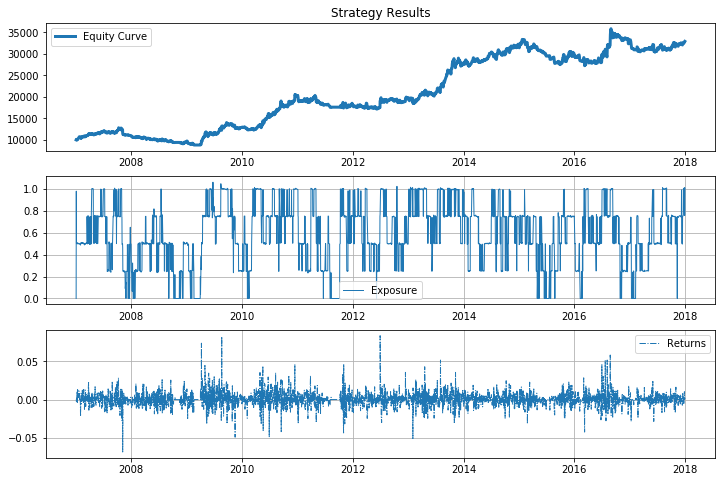

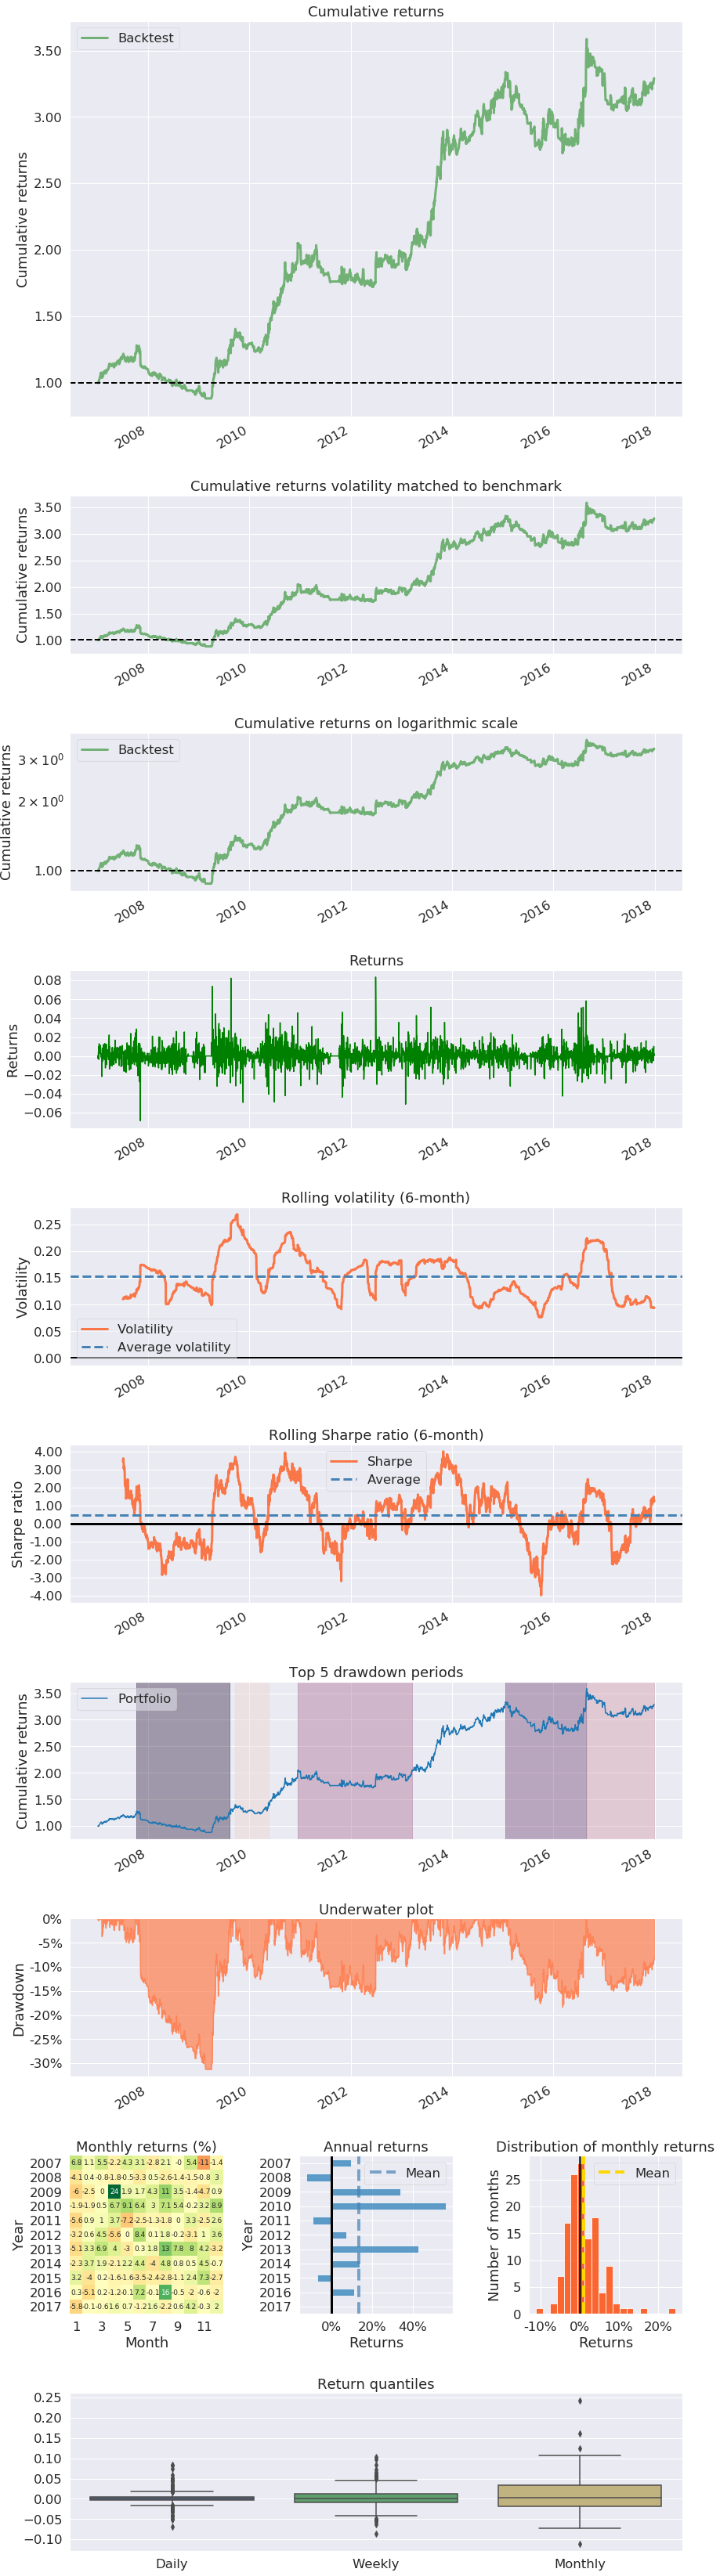

In [31]:
# Fire off the backtest
results = run_algorithm(start=start_date, end=end_date, 
                                initialize=initialize, analyze=analyze, 
                                handle_data=handle_data, 
                                capital_base=10000,data_frequency='daily') 

In [29]:
# Get the backtest data for a particular day
results.loc['2016-12-29']

algo_volatility                                                       86.457
algorithm_period_return                                          2.03415e+06
alpha                                                                   None
benchmark_period_return                                                    0
benchmark_volatility                                                       0
beta                                                                    None
capital_used                                                    -1.89387e+07
ending_cash                                                     -2.74418e+10
ending_exposure                                                  4.77833e+10
ending_value                                                     4.77833e+10
excess_return                                                              0
gross_leverage                                                       2.85918
long_exposure                                                    5.29717e+10

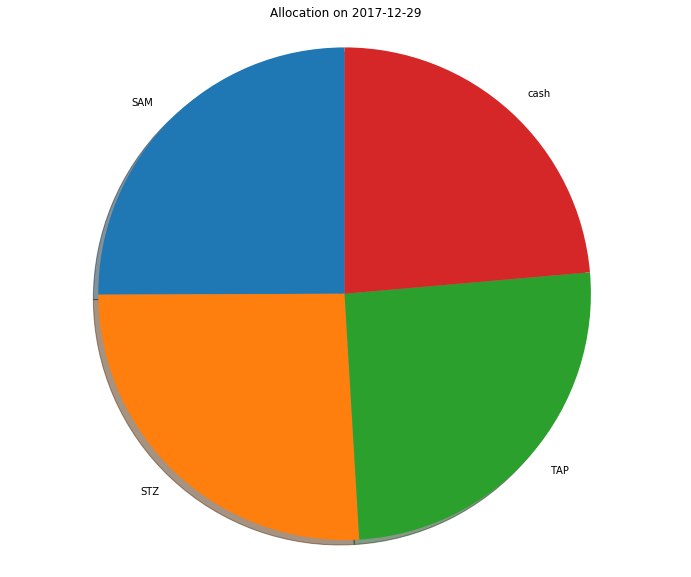

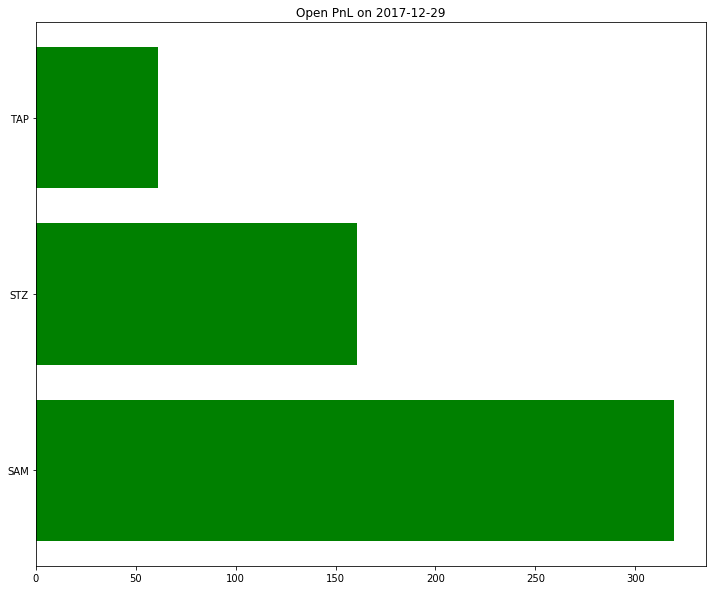

In [14]:
# Let's get a portfolio snapshot
# Import pandas and matplotlib
import pandas as pd
import matplotlib.pyplot as plt

# Select day to view
day = '2017-12-29'

# Get portfolio value and positions for this day
port_value = results.loc[day,'portfolio_value']
day_positions = results.loc[day,'positions']

# Empty DataFrame to store values
df = pd.DataFrame(columns=['value', 'pnl'])

# Populate DataFrame with position info
for pos in day_positions:
    ticker = pos['sid'].symbol 
    df.loc[ticker,'value'] = pos['amount'] * pos['last_sale_price']
    df.loc[ticker,'pnl'] = df.loc[ticker,'value'] - (pos['amount'] * pos['cost_basis'])
    
# Add cash position
df.loc['cash', ['value','pnl']] = [(port_value - df['value'].sum()), 0]    

# Make pie chart for allocations
fig, ax1 = plt.subplots(figsize=[12, 10])
ax1.pie(df['value'], labels=df.index, shadow=True, startangle=90)
ax1.axis('equal')
ax1.set_title('Allocation on {}'.format(day))
plt.show()

# Make bar chart for open PnL
fig, ax1 = plt.subplots(figsize=[12, 10])
pnl_df = df.drop('cash')
ax1.barh( pnl_df.index, pnl_df['pnl'],  align='center', color='green', ecolor='black')
ax1.set_title('Open PnL on {}'.format(day))
plt.show()
